<a href="https://colab.research.google.com/github/jonrib/AML-Project2/blob/main/AML_MP2_Ribikauskas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MP1: Deep Fast Fashion

Date: 2020.11.21

Author: © 2020 [Jonas Ribikauskas](https://www.linkedin.com/in/jonas-ribikauskas-4b8b5a138/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

The goal of this work is to create a deep learning model using [PyTorch](https://pytorch.org/), that is trained in under 3 minutes in [Google Colab](https://colab.research.google.com/) environment on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) data, gives the best possible testing performance. 

This template is partially based on [this solution](
https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d). 

You should select GPU in Google Colab: *Runtime -> Change runtime type -> Hardware accelerator: GPU*.

The performance will be measured on *Tesla P100* graphics card which is the most popular in Google Colab machines, but you will not always get a machine with this GPU. Other GPUs: Tesla P4, Tesla T4 are similar in performance to P100 (slightly faster on average), and K80 is slower. The speed also varies slightly based on other factors, like the Colab cloud usage load.

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

## Settings

Do not eddit!

On the reproducibility of experiments: https://pytorch.org/docs/stable/notes/randomness.html

In [2]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 1.0*corrects / batch_size
    return accuracy.item()
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Information on the obtained hardware

In [3]:
print('Torch version: %s' %torch.__version__)
if torch.cuda.is_available():
    print('GPU: %s' %torch.cuda.get_device_name()) 
else:
    print('GPU not available.')

Torch version: 1.7.0+cu101
GPU: Tesla T4


In [4]:
!nvidia-smi

Sun Nov 22 00:50:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    14W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

## Import the data

You can change the data transformations but not the splitting (50000:10000) between training and validation in this notebook. But you can use a different type of validation with this data in our other codes to find the best model and its hyper-parameters, as long as you don't touch testing data. 

In [6]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
# do not change this!
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainset, validset = torch.utils.data.random_split(dataset, [50000,10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

len(trainset), len(validset)

(50000, 10000)

### Show a couple of data points

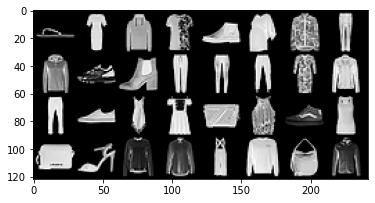

In [7]:
import matplotlib.pyplot as plt

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

## Report of the things tried and their validation results
links where various ideas were observed: 
*   https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d
*   https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy



| Model       | Testing accuracy | Validation accuracy | Training Time | Description                                       | Was it better than previous |
|-------------|------------------|---------------------|---------------|--------------------------------------------------|-----------------------------|
| Conv2Model  | 0.9251           | 0.9148              | 101504.55 ms  | A CNN with 2 layers                                     | First actual attempt                      |
| Conv2Model2 | 0.8637           | 0.8701              | 128997.31 ms  | A CNN with 2 layers (kernel size when pooling the same) | No. Significantly worse                        |
| Conv2Model3 | 0.9123           | 0.8959              | 128997.31 ms  | A CNN with 2 layers (removed padding)  | Yes. But not overall                          |
| Conv3Model  | 0.9314           | 0.9176              | 104588.16 ms  | A CNN with 3 layers                    | Yes. Overall best so far                              |
| Conv2Model4 | 0.9270           | 0.9191              | 115640.93 ms  | A CNN with 2 layers (extra linear)     | Yes. But not in terms of time and not the best overall                     |

Overall best: Conv3Model. 3 convolution layer CNN.
Other things I tried changing:
*   Data normalization only made results worse
*   4 layer CNN. Did not manage to get it working properly. Perhaps the given images are too small.


## Model no. 1

This model is a 2 convolution layer CNN where each layer's kernel size is 5, padding is 2.

In [8]:
class Conv2Model(nn.Module):
    def __init__(self):
        super(Conv2Model, self).__init__()
       
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.25)
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Model no. 2

This model is a 2 convolution layer CNN where each layer's kernel size is 5, padding is 0.

In [9]:
class Conv2Model2(nn.Module):
    def __init__(self):
        super(Conv2Model2, self).__init__()
       
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1))
        self.drop_out = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12 * 12 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Model no. 3

This model is a 2 convolution layer CNN where each layer's kernel size is 5, padding is 0. Pooling kernel size is 2, stride is 2.

In [10]:
class Conv2Model3(nn.Module):
    def __init__(self):
        super(Conv2Model3, self).__init__()
       
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.25)
        self.fc1 = nn.Linear(4 * 4 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Model no. 4

This model is a 3 convolution layer CNN where each layer's kernel size is 5, padding is 2. Pooling kernel size is 2, stride is 2.

In [11]:
class Conv3Model(nn.Module):
    def __init__(self):
        super(Conv3Model, self).__init__()
       
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.drop_out = nn.Dropout(0.25)
        self.fc1 = nn.Linear(3 * 3 * 96, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Model no. 5

This model is a 2 convolution layer CNN where each layer's kernel size is 5, padding is 2. Pooling kernel size is 2, stride is 2.

In [12]:
class Conv2Model4(nn.Module):
    def __init__(self):
        super(Conv2Model4, self).__init__()
       
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.25)
        self.fc1 = nn.Linear(7 * 7 * 64, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

### Learning parameters

You have a freedom here. But the model should stay the `model`. And the `num_epochs` should be such that training should not exceed 3 minutes on Tesla T100.

In [13]:
learning_rate = 0.001
num_epochs = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Conv3Model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

Do not edit! The training is only happening here.

In [14]:
# timing. do not alter!
start_timer = torch.cuda.Event(enable_timing=True)
end_timer = torch.cuda.Event(enable_timing=True)
start_timer.record()

# training stats
trainlosses = np.zeros(num_epochs)
trainaccs = np.zeros(num_epochs)
validaccs = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    train_running_loss /= len(trainloader)
    train_acc /= len(trainloader)

    valid_acc = 0.0
    for i, (images, labels) in enumerate(validloader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        valid_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    valid_acc /= len(validloader)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f | Validation Accuracy: %.4f' \
          %(epoch, train_running_loss, train_acc, valid_acc)) 
            
    trainlosses[epoch] = train_running_loss
    trainaccs[epoch] = train_acc
    validaccs[epoch] = valid_acc

# timing. do not alter!
end_timer.record()
torch.cuda.synchronize()
elapsed_time = start_timer.elapsed_time(end_timer)
max_training_time = 3*60*1000
print('Training time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

Epoch: 0 | Loss: 0.4584 | Train Accuracy: 0.8300 | Validation Accuracy: 0.8840
Epoch: 1 | Loss: 0.3038 | Train Accuracy: 0.8882 | Validation Accuracy: 0.8990
Epoch: 2 | Loss: 0.2616 | Train Accuracy: 0.9038 | Validation Accuracy: 0.8964
Epoch: 3 | Loss: 0.2370 | Train Accuracy: 0.9125 | Validation Accuracy: 0.9044
Epoch: 4 | Loss: 0.2171 | Train Accuracy: 0.9204 | Validation Accuracy: 0.9167
Epoch: 5 | Loss: 0.1973 | Train Accuracy: 0.9263 | Validation Accuracy: 0.8977
Epoch: 6 | Loss: 0.1787 | Train Accuracy: 0.9339 | Validation Accuracy: 0.9133
Epoch: 7 | Loss: 0.1659 | Train Accuracy: 0.9377 | Validation Accuracy: 0.9104
Training time: 106441.66 ms (max 180000 ms.)


Plot training loss, training and validation accuracy over training epochs.

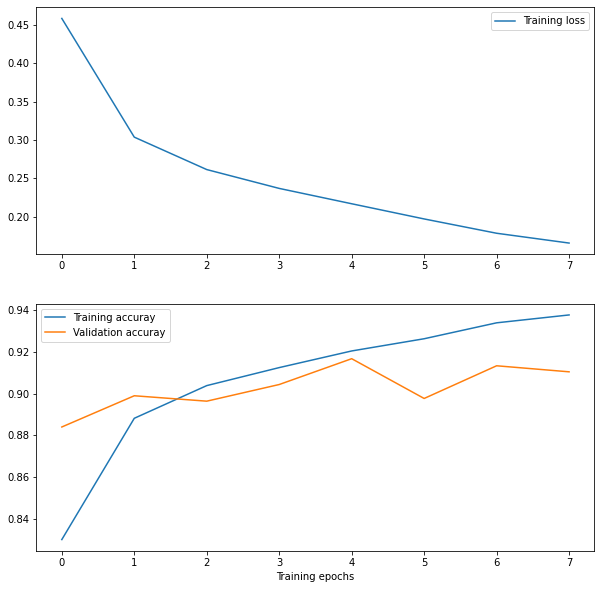

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trainlosses)
plt.legend(['Training loss']) 
plt.subplot(2,1,2)
plt.plot(trainaccs)
plt.plot(validaccs)
plt.xlabel('Training epochs')
plt.legend(['Training accuray','Validation accuray'])